# Objectives:

1. Get total sales per invoice and identify the top 5 invoices.
2. Compute total sales per customer and list the top 5 customers.
3. Identify the top 5 selling items during the specified period.
4. Determine the most frequently purchased item pairs by customers and display the top 20 pairs.
5. Recommend 10 pairs of items for a new promotion targeting items with low sales volume.

# Importing Required Packages

In [16]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from wordcloud import WordCloud

# Loading Data and Sampling

In [8]:
df = pd.read_csv("online_retail_II.csv")
sample = df.sample(n=200000, random_state=1190652)

sem = pd.DataFrame(sample.sem(numeric_only= True), columns=['SEM'])
print("Table: Standard Error of Means for numerical columns:")
display(sem)

Table: Standard Error of Means for numerical columns:


,SEM
Quantity,0.413771
Price,0.287015
Customer ID,4.313394


In [21]:
def missing_values(df):
    missing_count = df.isnull().sum()
    missing_percetanges = pd.DataFrame({
        'Column': missing_count.index,
        'Counts': missing_count.values,
        'Percentage': missing_count.values / len(df) * 100  
    })
    return  missing_percetanges



def explore_sample(sample):
    head = pd.DataFrame(sample.head())
    tail = pd.DataFrame(sample.tail())
    nunique = pd.DataFrame(sample.nunique(), columns=["#_of_Unique"])
    describe = pd.DataFrame(sample.describe())
    dtypes =  pd.DataFrame(sample.dtypes, columns=["Datatype"])
    results = {
        'Table: Dataset Head:':head,
        'Table: Dataset Tail:':tail,
        'Table: Dataset Numerical Describtion: ':describe,
        'Table: Missing Values By Percentage': missing_values(sample), 
        'Table: Dataset Columns Data types: ':dtypes,
        'Table: Number of uniques in the datasets:':nunique}
    return results

def print_sample_exploration(results):
    """
    Prints a beautufil display of each of the exploration dataframe
    Args:
        results (dict): contains exploration outputs with the title as key
    Returns:
        nothing
    """
    for operation, dataframe in results.items():
        print(f"{operation}")
        if operation == 'Table 6: Missing Values By Percentage':
            print("Total Sum of Missing Percetange: ", dataframe['Percentage'].sum())
        display(dataframe)


print_sample_exploration(explore_sample(sample))

Table: Dataset Head:


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
803443,561203,22953,BIRTHDAY PARTY CORDON BARRIER TAPE,12,2011-07-25 15:17:00,1.25,14232.0,United Kingdom
607418,543182,22726,ALARM CLOCK BAKELIKE GREEN,3,2011-02-04 10:40:00,7.46,NaN,United Kingdom
117428,500567,47586A,PINK FAIRY CAKE CUSHION COVER,24,2010-03-08 15:49:00,0.85,13694.0,United Kingdom
299616,518570,35961,FOLKART ZINC HEART CHRISTMAS DEC,1,2010-08-10 11:49:00,1.66,NaN,United Kingdom
613909,543803,22525,CHILDRENS GARDEN GLOVES PINK,5,2011-02-13 12:05:00,1.25,17126.0,United Kingdom


Table: Dataset Tail:


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
107865,499765,21916,SET 12 RETRO WHITE CHALK STICKS,1,2010-03-02 13:15:00,0.81,NaN,United Kingdom
1000423,576857,23102,SILVER HEARTS TABLE DECORATION,2,2011-11-16 15:52:00,0.83,12748.0,United Kingdom
827091,563350,22111,SCOTTIE DOG HOT WATER BOTTLE,2,2011-08-15 14:10:00,4.95,14498.0,United Kingdom
553404,538576,21187,WHITE BELL HONEYCOMB PAPER GARLAND,2,2010-12-13 11:29:00,1.65,14498.0,United Kingdom
47491,493817,21306,SET/4 DAISY MIRROR MAGNETS,6,2010-01-07 12:22:00,2.10,16641.0,United Kingdom


Table: Dataset Numerical Describtion: 


,Quantity,Price,Customer ID
count,200000.000000,200000.000000,154545.000000
mean,9.487405,4.505168,15324.988269
std,185.044141,128.357150,1695.690684
min,-74215.000000,-44031.790000,12346.000000
25%,1.000000,1.250000,13975.000000
50%,3.000000,2.100000,15251.000000
75%,10.000000,4.130000,16797.000000
max,12960.000000,18910.690000,18287.000000


Table: Missing Values By Percentage


,Column,Counts,Percentage
0,Invoice,0,0.0000
1,StockCode,0,0.0000
2,Description,818,0.4090
3,Quantity,0,0.0000
4,InvoiceDate,0,0.0000
5,Price,0,0.0000
6,Customer ID,45455,22.7275
7,Country,0,0.0000


Table: Dataset Columns Data types: 


,Datatype
Invoice,object
StockCode,object
Description,object
Quantity,int64
InvoiceDate,object
Price,float64
Customer ID,float64
Country,object


Table: Number of uniques in the datasets:


,#_of_Unique
Invoice,36313
StockCode,4698
Description,5043
Quantity,533
InvoiceDate,33985
Price,1009
Customer ID,5575
Country,43


In [22]:
def handle_date(sample):
    """ 
    Handles date high cardenality
    Args: 
        sample (pd.Dataframe): contains datset
    Return:
        (pd.Dataframe) handeled with day, month, year and time columns added
    """    
    sample['InvoiceDate'] = pd.to_datetime(sample['InvoiceDate'])
    sample['InvoiceYear'] = sample['InvoiceDate'].dt.year
    sample['InvoiceMonth'] = sample['InvoiceDate'].dt.month
    sample['InvoiceDay'] = sample['InvoiceDate'].dt.day
    sample['InvoiceTime'] = sample['InvoiceDate'].dt.time
    sample = sample.drop('InvoiceDate', axis=1)
    return sample


sample = handle_date(sample)

In [23]:
def get_total(row):
    """
    Calcualtes the total prices by multiplication and considering quantity
    Args:
        row of the dataframe
    Returns:
        Total price  that is calculated by multiplication of Quantity*Price 
    """
    return row["Quantity"] * row["Price"]

sample['total_price'] = sample.apply(get_total, axis=1)


In [24]:
sample.head()

,Invoice,StockCode,Description,Quantity,Price,Customer ID,Country,InvoiceYear,InvoiceMonth,InvoiceDay,InvoiceTime,total_price
803443,561203,22953,BIRTHDAY PARTY CORDON BARRIER TAPE,12,1.25,14232.0,United Kingdom,2011,7,25,15:17:00,15.00
607418,543182,22726,ALARM CLOCK BAKELIKE GREEN,3,7.46,NaN,United Kingdom,2011,2,4,10:40:00,22.38
117428,500567,47586A,PINK FAIRY CAKE CUSHION COVER,24,0.85,13694.0,United Kingdom,2010,3,8,15:49:00,20.40
299616,518570,35961,FOLKART ZINC HEART CHRISTMAS DEC,1,1.66,NaN,United Kingdom,2010,8,10,11:49:00,1.66
613909,543803,22525,CHILDRENS GARDEN GLOVES PINK,5,1.25,17126.0,United Kingdom,2011,2,13,12:05:00,6.25


In [25]:
regular_invoices = sample[~sample['Invoice'].str.startswith('C')]
canceled_invoices = sample[sample['Invoice'].str.startswith('C')]
hourly_sales = sample.groupby('InvoiceTime')['total_price'].sum()

regular_sum = regular_invoices['total_price'].sum()
canceled_sum = canceled_invoices['total_price'].sum()
sales_ratio = canceled_sum / 3727
peak_sales_hour = hourly_sales.idxmax()

print(f"The peak sales hour is at {peak_sales_hour} o'clock.")
print("Total Sales for Regular Invoices:", regular_sum)
print("Total Sales for Canceled Invoices:", canceled_sum)
print("Ratio of Total Sales (Canceled/Total inovices):", canceled_invoices.shape[0]/len(sample.groupby(sample['Invoice'])))

The peak sales hour is at 15:28:00 o'clock.
Total Sales for Regular Invoices: 3858108.3240000005
Total Sales for Canceled Invoices: -313185.53
Ratio of Total Sales (Canceled/Total inovices): 0.10263541982210228


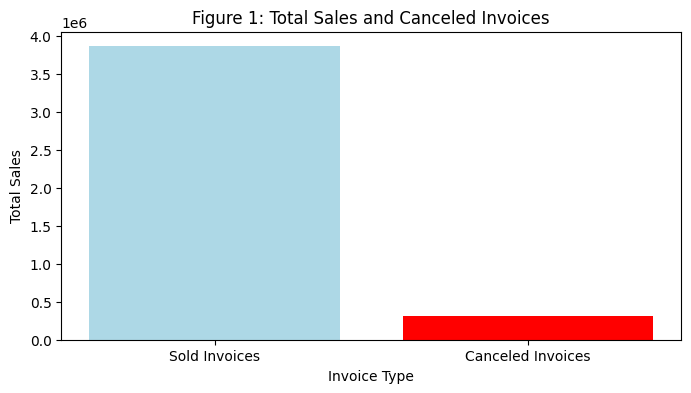

In [29]:
plt.figure(figsize =(8,4))
plt.bar(['Sold Invoices', 'Canceled Invoices'], [regular_sum, canceled_sum*-1], color=['lightblue', 'red'])
plt.xlabel('Invoice Type')
plt.ylabel('Total Sales')
plt.title('Figure 1: Total Sales and Canceled Invoices')
plt.show()

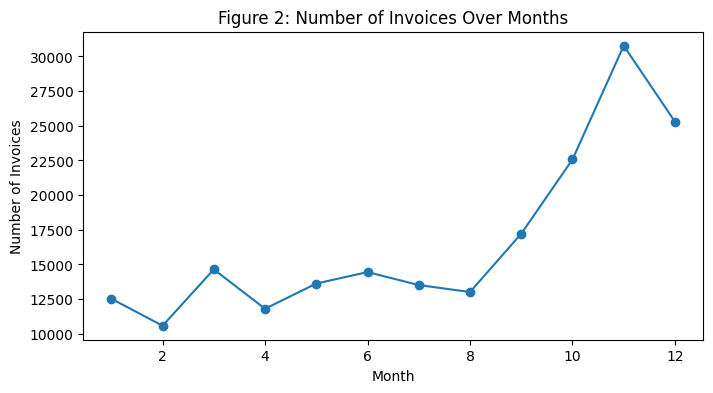

In [30]:
plt.figure(figsize =(8,4))
sample.groupby('InvoiceMonth')['Invoice'].count().plot(marker='o')
plt.title('Figure 2: Number of Invoices Over Months')
plt.xlabel('Month')
plt.ylabel('Number of Invoices')
plt.show()

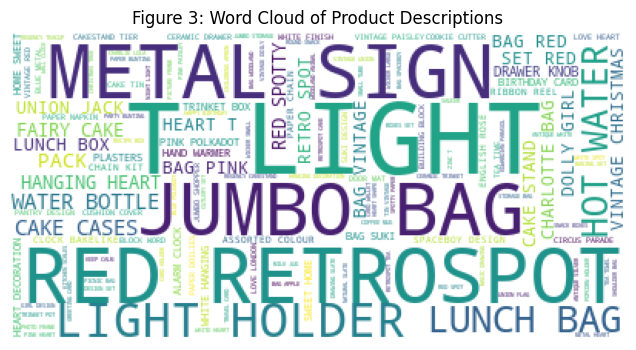

In [31]:
plt.figure(figsize =(8,4))
words = ' '.join(sample['Description'].dropna())
wordcloud = WordCloud(background_color='white').generate(words)
plt.imshow(wordcloud)
plt.title('Figure 3: Word Cloud of Product Descriptions')
plt.axis('off')
plt.show()

In [32]:
print("The top 5 total Sales and their invovice:")
sample.groupby(sample['Invoice'])['total_price'].sum().nlargest(5)

The top 5 total Sales and their invovice:


Invoice
556444    38970.00
530715    15818.40
537632    13541.33
574941    11318.40
572209     9855.00
Name: total_price, dtype: float64

In [33]:
print("The top 5 buyers by Id:")
sample.groupby(sample['Customer ID'])['total_price'].sum().nlargest(5)

The top 5 buyers by Id:


Customer ID
18102.0    103610.73
14646.0     94118.39
17450.0     53062.80
14156.0     48606.45
14911.0     46425.48
Name: total_price, dtype: float64

In [34]:
def print_top_items(sample, top5):
    """
    Get top5 series and print the descriptions for each stockItem
    Args:
        sample (pd.Dataframe): sample of the dataset
        top5 (pd.Series): top 5 indexed by the Stockcode
    Returns:
        Nothing but displays teh outputs
    """
    print("The top selling items:")
    for stockcode in top5.index:
        print("Stock Code: ", stockcode)
        descriptions = sample[sample['StockCode'] == stockcode]['Description'].unique() #SOme items have multiple descriptions
        print("     Descriptions:", descriptions)

In [35]:
top5 = sample.groupby('StockCode')['total_price'].sum().nlargest(5)
print_top_items(sample, top5)

The top selling items:
Stock Code:  DOT
     Descriptions: ['DOTCOM POSTAGE']
Stock Code:  22423
     Descriptions: ['REGENCY CAKESTAND 3 TIER' 'faulty' 'damages']
Stock Code:  85123A
     Descriptions: ['WHITE HANGING HEART T-LIGHT HOLDER' 'CREAM HANGING HEART T-LIGHT HOLDER']
Stock Code:  22502
     Descriptions: ['PICNIC BASKET WICKER SMALL' 'reverse 21/5/10 adjustment' nan
 'PICNIC BASKET WICKER 60 PIECES']
Stock Code:  85099B
     Descriptions: ['JUMBO BAG RED RETROSPOT' 'JUMBO BAG RED WHITE SPOTTY '
 'RED RETROSPOT JUMBO BAG ' 'missing']


In [36]:
def only_pairs(row):
    """
    Make the row into a list and keeps the pairs
    Args:
        row: (np.array): the row in the df
    Rturns:
        list of row and None if len is larger than 2
    """
    if len(list(row)) == 2:
        return list(row)
    else:
        return None

In [37]:
def print_top_20(sample, top20):
    """
    Get top10 series and print the descriptions for each
    Args:
        sample (pd.Dataframe): sample of the dataset
        top5 (pd.Series): top 20 indexed by the Stockcode
    Returns:
        Nothing but displays the outputs
    """
    print("The most frequently purchased item pairs are:")
    i = 0
    for stockcode in top20.index:
        print("Pairs # : ", i)
        print("Stock Codes: ", stockcode)
        for code in stockcode:
            descriptions = sample[sample['StockCode'] == code]['Description'].unique() #SOme items have multiple descriptions
            print("     Descriptions:", descriptions)
        print("\n")
        i = i+1

In [38]:
pairs_transactions = pd.DataFrame(sample.groupby(['Customer ID', 'Invoice'])['StockCode'].apply(only_pairs).dropna())
pairs_transactions.head()

StockCode
Customer ID Invoice                
12346.0     513774   [20685, 22689]
12347.0     556201   [22375, 23146]
            562032   [23297, 23146]
12348.0     539318   [22952, 21211]
12352.0     535838   [21181, 21756]

In [39]:
top20 = pairs_transactions['StockCode'].value_counts().head(20)
top20.head()

[22698, 22423]    3
[20727, 20725]    3
[21977, 21212]    3
[22625, 22624]    3
[21175, 21181]    3
Name: StockCode, dtype: int64

In [40]:
print_top_20(sample,top20)

The most frequently purchased item pairs are:
Pairs # :  0
Stock Codes:  ['22698', '22423']
     Descriptions: ['PINK REGENCY TEACUP AND SAUCER' nan 'TEACUP AND SAUCER REGENCY PINK']
     Descriptions: ['REGENCY CAKESTAND 3 TIER' 'faulty' 'damages']


Pairs # :  1
Stock Codes:  ['20727', '20725']
     Descriptions: ['LUNCH BAG  BLACK SKULL.']
     Descriptions: ['LUNCH BAG RED RETROSPOT' 'LUNCH BAG RED SPOTTY']


Pairs # :  2
Stock Codes:  ['21977', '21212']
     Descriptions: ['PACK OF 60 PINK PAISLEY CAKE CASES']
     Descriptions: ['PACK OF 72 RETRO SPOT CAKE CASES' 'PACK OF 72 RETROSPOT CAKE CASES']


Pairs # :  3
Stock Codes:  ['22625', '22624']
     Descriptions: ['RED KITCHEN SCALES']
     Descriptions: ['IVORY KITCHEN SCALES']


Pairs # :  4
Stock Codes:  ['21175', '21181']
     Descriptions: ['GIN + TONIC DIET METAL SIGN' 'GIN AND TONIC DIET METAL SIGN']
     Descriptions: ['PLEASE ONE PERSON METAL SIGN' nan 'PLEASE ONE PERSON  METAL SIGN']


Pairs # :  5
Stock Codes:  ['22041

In [41]:
pd.DataFrame(top20.index.to_flat_index()).to_csv('top_20_pairs.csv', header='StockCode')

In [42]:
top10 = sample.groupby('StockCode')['total_price'].sum().nlargest(10)
print_top_items(sample, top10)

The top selling items:
Stock Code:  DOT
     Descriptions: ['DOTCOM POSTAGE']
Stock Code:  22423
     Descriptions: ['REGENCY CAKESTAND 3 TIER' 'faulty' 'damages']
Stock Code:  85123A
     Descriptions: ['WHITE HANGING HEART T-LIGHT HOLDER' 'CREAM HANGING HEART T-LIGHT HOLDER']
Stock Code:  22502
     Descriptions: ['PICNIC BASKET WICKER SMALL' 'reverse 21/5/10 adjustment' nan
 'PICNIC BASKET WICKER 60 PIECES']
Stock Code:  85099B
     Descriptions: ['JUMBO BAG RED RETROSPOT' 'JUMBO BAG RED WHITE SPOTTY '
 'RED RETROSPOT JUMBO BAG ' 'missing']
Stock Code:  47566
     Descriptions: ['PARTY BUNTING' nan]
Stock Code:  84347
     Descriptions: ['ROTATING SILVER ANGELS T-LIGHT HLDR' nan]
Stock Code:  84879
     Descriptions: ['ASSORTED COLOUR BIRD ORNAMENT']
Stock Code:  22086
     Descriptions: ["PAPER CHAIN KIT 50'S CHRISTMAS "]
Stock Code:  22197
     Descriptions: ['POPCORN HOLDER' 'SMALL POPCORN HOLDER' 'POPCORN HOLDER , SMALL ']


In [43]:
topBottom10 = sample.groupby('StockCode')['total_price'].sum().nsmallest(20)
print_top_items(sample, topBottom10)

The top selling items:
Stock Code:  23166
     Descriptions: ['MEDIUM CERAMIC TOP STORAGE JAR']
Stock Code:  B
     Descriptions: ['Adjust bad debt']
Stock Code:  AMAZONFEE
     Descriptions: ['AMAZON FEE']
Stock Code:  M
     Descriptions: ['Manual']
Stock Code:  BANK CHARGES
     Descriptions: ['Bank Charges' ' Bank Charges']
Stock Code:  D
     Descriptions: ['Discount']
Stock Code:  CRUK
     Descriptions: ['CRUK Commission']
Stock Code:  S
     Descriptions: ['SAMPLES']
Stock Code:  21096
     Descriptions: ['SET/6 FRUIT SALAD  PAPER PLATES']
Stock Code:  85160A
     Descriptions: ['WHITE BIRD GARDEN DESIGN MUG']
Stock Code:  21088
     Descriptions: ['SET/6 FRUIT SALAD PAPER CUPS']
Stock Code:  20840
     Descriptions: ['FRENCH FLORAL CUSHION COVER ']
Stock Code:  22102
     Descriptions: ['MIRROR MOSAIC T-LIGHT HOLDER ']
Stock Code:  20893
     Descriptions: ['HANGING BAUBLE T-LIGHT HOLDER SMALL' 'damages']
Stock Code:  79323G
     Descriptions: ['GOLD  CHERRY LIGHTS' nan]
Stock

In [44]:
topBottom10set = set(topBottom10.index) - set(['B', 'AMAZONFEE', 'M', 'BANK CHARGES', 'D', 'CRUK', 'S'])
topBottom10List = list(topBottom10set)[:10]
topBottom10List

['47351B',
 '85109',
 '79323G',
 '10138',
 '21096',
 '22102',
 '23166',
 '21088',
 '85160A',
 '16053']

In [45]:
top10List = list(top10.index)
top10List

['DOT',
 '22423',
 '85123A',
 '22502',
 '85099B',
 '47566',
 '84347',
 '84879',
 '22086',
 '22197']

In [46]:
np.random.seed(1190652)
np.random.shuffle(top10List)
np.random.shuffle(topBottom10List)

promotion_pairs = pd.DataFrame((zip(top10List, topBottom10List)))

print("The Promotion pairs:")
promotion_pairs

The Promotion pairs:


,0,1
0,22423,21096
1,22502,10138
2,85099B,21088
3,DOT,47351B
4,47566,85109
5,85123A,22102
6,84347,79323G
7,22197,85160A
8,84879,23166
9,22086,16053


In [47]:
promotion_pairs.to_csv('promotion_pairs.csv')

In [48]:
print("The Promotion pairs:")
promotion_pairs

The Promotion pairs:


,0,1
0,22423,21096
1,22502,10138
2,85099B,21088
3,DOT,47351B
4,47566,85109
5,85123A,22102
6,84347,79323G
7,22197,85160A
8,84879,23166
9,22086,16053
